In [56]:
%matplotlib inline
import os
from glob import glob

import calendar
import numpy as np
import xarray as xr
import xesmf as xe
import dask
import esmlab

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cmocean
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

import util
import shutil

## Import Annual Summer Data

In [60]:
ds_djf = xr.open_zarr('data/cesm-le-fields-djf-epoch-mean2.zarr')
ds_djf

<xarray.Dataset>
Dimensions:    (epoch: 2, length: 4, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch      (epoch) <U9 '1985-2005' '2070-2100'
  * length     (length) float64 20.0 30.0 40.0 50.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC      (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP        (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    SST        (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

## Prep data to plot
* lat / lon assigned
* means calculated
* function to make a midpoint
* attempt to fix pop grid for polar plotting

In [61]:
# Lat Lon Checks
lon = ds_djf.TLONG.values
lat = ds_djf.TLAT.values
# Basic Means
kgp_mean = ds_djf['KGP'].mean('member_id')
sst_mean = ds_djf['SST'].mean('member_id')
chl_mean = ds_djf['Chl_surf'].mean('member_id')
ice_mean = ds_djf['IFRAC'].mean('member_id')

In [62]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [68]:
ds_plot = util.pop_add_cyclic(sst_mean.sel(epoch = '1985-2005'))

NotImplementedError: Item assignment with <class 'tuple'> not supported

### Plot: 
running into this strange error where there's a circle in the middle - adding the kmt arguement doesn't help, it makes the continent blue, and the add_pop_cyclic also doesn't work and I don't know what tuple is messing it up

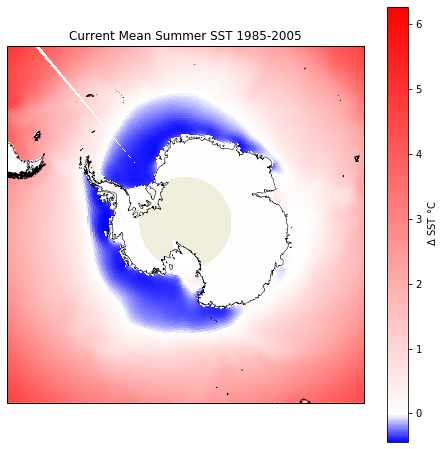

In [63]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Current Mean Summer SST 1985-2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, sst_mean.sel(epoch = '1985-2005'), cmap='bwr', norm=MidpointNormalize(midpoint=0.),
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label=' $\Delta$ SST °C')
    


## Plot again... using contourf
things get even more strange, but the kmt  0 does help this time

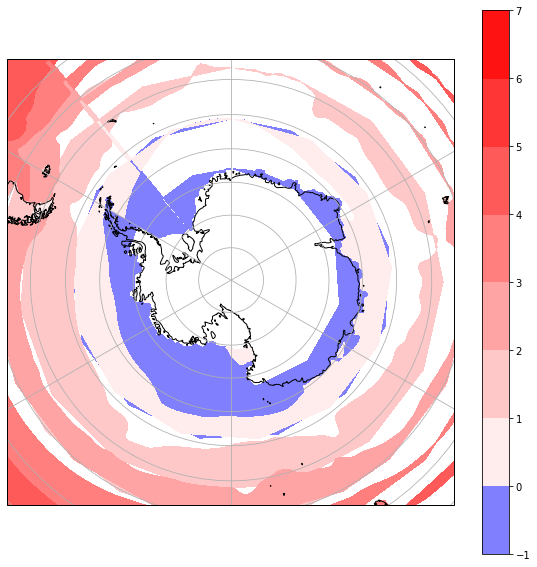

In [71]:
field = sst_mean.sel(epoch = '1985-2005').where(sst_mean.KMT > 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cf = ax.contourf(lon, lat, field,
                 cmap='bwr', norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder

fig.colorbar(cf, ax=ax)

## Once more but for Ice with pcolormesh: 

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


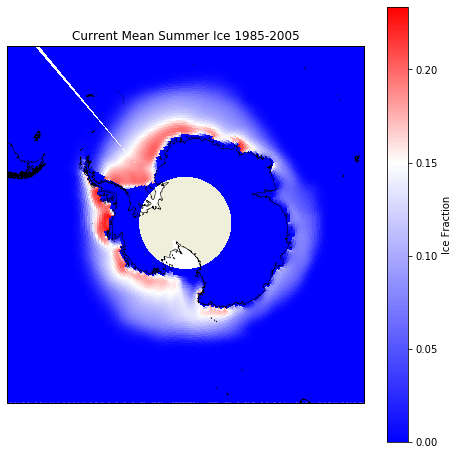

In [74]:
field = ice_mean.sel(epoch = '1985-2005').where(ice_mean.KMT > 0)


fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Current Mean Summer Ice 1985-2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, field, cmap='bwr', norm=MidpointNormalize(midpoint=0.15),
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Ice Fraction')
    


___
## Moving on to plot KGP and see if it makes sense:
steps:
* make the strange colormap that matches the 0,1,2,3,4,5 thing that is used in murphy, hill, and veyita to display MONTHLY growth rate (stepping the daily growth rate equation forward in time)

In [36]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-1, vmax=5)
        fig.colorbar(psm, ax=ax)
    plt.show()

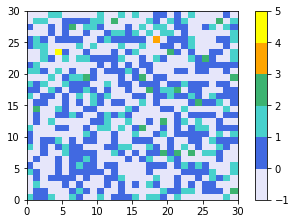

In [55]:
cmap = ListedColormap(["lavender", "royalblue", "mediumturquoise", "mediumseagreen", "orange", "yellow" ], name='murphy')
#cmap = ListedColormap([ "royalblue", "mediumturquoise", "mediumseagreen", "orange" ], name='murphy')
#cmap.set_over('red')
#cmap.set_under('lavender')
plot_examples([cmap])

### Plot KGP Version 1

Plot to match the other papers using `vmin` and `vmax` to make the colorbar work
and make it pseudo monthly... KGP * 30 days

* the KMT > 0 pretty much fixes the circle issue, but the missing point still is visable

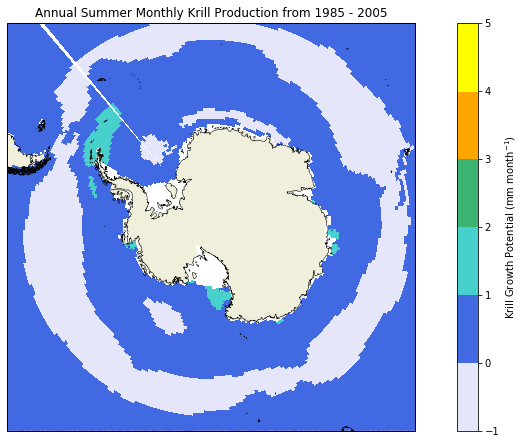

In [82]:
fig = plt.figure(figsize=(15,7.5))

field= kgp_mean.sel(epoch = '1985-2005').sel(length = '40').where(kgp_mean.KMT >0)

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Annual Summer Monthly Krill Production from 1985 - 2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, field*30, cmap=cmap,
                 vmin = -1, vmax = 5,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mm month$^{-1}$)')
#fig.savefig('Seasonal DJF Climatologies from 30 year epochs CESM-LE: 1985-2005', bbox_inches='tight') #,format='pdf');


### Plot KGP Version 2

take out the`vmin` and `vmax` ...
and make it pseudo monthly: KGP * 30 days


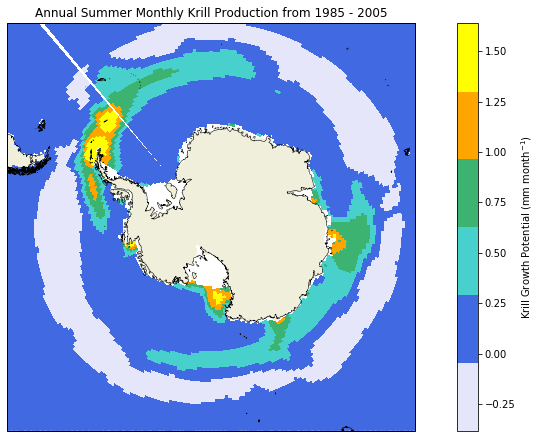

In [84]:
fig = plt.figure(figsize=(15,7.5))

field= kgp_mean.sel(epoch = '1985-2005').sel(length = '40').where(kgp_mean.KMT >0)

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Annual Summer Monthly Krill Production from 1985 - 2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, field*30, cmap=cmap,
                 #vmin = -1, vmax = 5,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mm month$^{-1}$)')
#fig.savefig('Seasonal DJF Climatologies from 30 year epochs CESM-LE: 1985-2005', bbox_inches='tight') #,format='pdf');
